<a href="https://colab.research.google.com/github/staerkjoe/NLP_colab/blob/main/E03_rnn_text_generation_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 3.2: Understanding Gating in RNNs

ITU KSAMLNL1KU - Advanced Machine Learning for Natural Language Processing 2025

by Stefan Heinrich, Eisuke Okuda, Jonathan Tiedchen,
& material by Kevin Murphy and Chris Bishop.

This notebook is based on the Tensorflow Tutorial https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_generation.ipynb.

All info and static material: https://learnit.itu.dk/course/view.php?id=3024752

-------------------------------------------------------------------------------

*Hint*: Before you read through the notebook, hit 'Run all' in Colab or your local environment since some steps will need some time and better already run in the background.

### Text generation with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate text using a character-based RNN. You will work with a dataset of Shakespeare's writing from Andrej Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Given a sequence of characters from this data ("Shakespear"), train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

Note: Enable GPU acceleration to execute this notebook faster. In Colab: *Runtime > Change runtime type > Hardware accelerator > GPU*.

This tutorial includes runnable code implemented using [keras](https://www.tensorflow.org/guide/keras/sequential_model) and [eager execution](https://www.tensorflow.org/guide/eager). The following is the sample output when the model in this tutorial trained for 30 epochs, and started with the prompt "Q":

#### Dependencies: import TensorFlow and other libraries

In [1]:
import tensorflow as tf
import tf_keras as keras
# note: tensorflow 2.17 onwards uses tf.keras 3.0 internally,
# which seem to be still bugged and inconsistent.
# We therefore use tf_keras in according to tensorflow version.

import numpy as np
import os
import time

#### Load and pre-process the data

##### Download and read:

<pre>
QUEENE:
I had thought thou hadst a Roman; for the oracle,
Thus by All bids the man against the word,
Which are so weak of care, by old care done;
Your children were in your holy love,
And the precipitation through the bleeding throne.

BISHOP OF ELY:
Marry, and will, my lord, to weep in such a one were prettiest;
Yet now I was adopted heir
Of the world's lamentable day,
To watch the next way with his father with his face?

ESCALUS:
The cause why then we are all resolved more sons.

VOLUMNIA:
O, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, it is no sin it should be dead,
And love and pale as any will to that word.

QUEEN ELIZABETH:
But how long have I heard the soul for this world,
And show his hands of life be proved to stand.

PETRUCHIO:
I say he look'd on, if I must be content
To stay him from the fatal of our country's bliss.
His lordship pluck'd from this sentence then for prey,
And then let us twain, being the moon,
were she such a case as fills m
</pre>

*Note*: While some of the sentences are grammatical, most do not make sense. The model has not learned the meaning of words, but consider:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text.

* The structure of the output resembles a play—blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* As demonstrated below, the model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.

In [2]:
!mkdir "../data"
!curl "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt" -o "../data/shakespeare.txt"
path_to_file = '../data/shakespeare.txt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1089k  100 1089k    0     0  5696k      0 --:--:-- --:--:-- --:--:-- 5673k


In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


##### Process the text (vectorize)

Before training, you need to convert the strings to a numerical representation.

The `keras.layers.StringLookup` layer can convert each character into a numeric ID. It just needs the text to be split into tokens first.

In [6]:
example_texts = ['abcdefg', 'xyz']
# gives back a byte string that why the b''

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Now create the `keras.layers.StringLookup` layer:

In [7]:
ids_from_chars = keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)
# Converts characters to integer IDs and vice versa.
# Enables the model to work with numerical data.

It converts from tokens to character IDs:

In [8]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Since the goal of this tutorial is to generate text, it will also be important to invert this representation and recover human-readable strings from it. For this you can use `keras.layers.StringLookup(..., invert=True)`.  

Note: Here instead of passing the original vocabulary generated with `sorted(set(text))` use the `get_vocabulary()` method of the `keras.layers.StringLookup` layer so that the `[UNK]` tokens is set the same way.

In [9]:
chars_from_ids = keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

This layer recovers the characters from the vectors of IDs, and returns them as a `tf.RaggedTensor` of characters:

In [10]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

You can `tf.strings.reduce_join` to join the characters back into strings.

In [11]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [12]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

#### The prediction (generation) task

Given a character, or a sequence of characters, what is the most probable next character? This is the task you're training the model to perform. The input to the model will be a sequence of characters, and you train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?


##### Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [13]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [14]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [15]:
seq_length = 100


The `batch` method lets you easily convert these individual characters to sequences of the desired size.

In [16]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


It's easier to see what this is doing if you join the tokens back into strings:

In [17]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For training you'll need a dataset of `(input, label)` pairs. Where `input` and
`label` are sequences. At each time step the input is the current character and the label is the next character.

Here's a function that takes a sequence as input, duplicates, and shifts it to align the input and label for each timestep:

In [18]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [19]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [20]:
dataset = sequences.map(split_input_target)

In [21]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


##### Create training batches

You used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, you need to shuffle the data and pack it into batches.

In [22]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000 # TensorFlow will keep up to 10,000 items in a buffer and shuffle them randomly

dataset = (
    dataset
    .shuffle(BUFFER_SIZE) # Randomizes order of examples
    .batch(BATCH_SIZE, drop_remainder=True) # Groups data into batches of 64 sequences
    .prefetch(tf.data.experimental.AUTOTUNE)) # TensorFlow already prepares the next batch in the background

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

#### Build The Model

**Your Tasks**:
- Modify the example to run with the SimpleRNN instead of the GRU and note down your results as a baseline. How did the network perform (quality)?
- Now run the model using GRU: what are the major effects in training (speed and convergence) and results (quality)?
- Modify the example to run with LSTM cells instead:
	- What is the effect?
	- Is the performance different than compared to using GRU?
- Compare the parameters of the needed number for decent performance between GRU, LSTM and the baseline (the baseline/SimpleRNN might not converge)?

This section defines the model as a `keras.Model` subclass (For details see [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)).

This model has three layers:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map each character-ID to a vector with `embedding_dim` dimensions;
* `keras.layers.GRU`: A type of RNN with size `units=rnn_units` (You can also use an LSTM layer here.)
* `keras.layers.Dense`: The output layer, with `vocab_size` outputs. It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.

In [23]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [37]:
class MyModel(keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
    self.LSTM = keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False, **kwargs):
      x = self.embedding(inputs, training=training)
      if states is None:
          states = self.LSTM.get_initial_state(x)
      x, state_h, state_c = self.LSTM(x, initial_state=states, training=training)
      x = self.dense(x, training=training)
      if return_state:
          return x, [state_h, state_c]
      else:
          return x

In [38]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![A drawing of the data passing through the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/text_generation_training.png?raw=1)

Note: For training you could use a `keras.Sequential` model here. To  generate text later you'll need to manage the RNN's internal state. It's simpler to include the state input and output options upfront, than it is to rearrange the model architecture later. For more details see the [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse).

##### Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [39]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is `100` but the model can be run on inputs of any length:

In [40]:
model.summary()

Model: "my_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     multiple                  16896     
                                                                 
 lstm_4 (LSTM)               multiple                  5246976   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 5331522 (20.34 MB)
Trainable params: 5331522 (20.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


To get actual predictions from the model you need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Note: It is important to _sample_ from this distribution as taking the _argmax_ of the distribution can easily get the model stuck in a loop.

Try it for the first example in the batch:

guesses from untrained weights
- It’s a sanity check: You confirm the model architecture works and outputs the expected shape.
- You can inspect the logits, sample from them, and even decode them into characters.
- It helps you understand how the model behaves before learning anything.

In [41]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [42]:
sampled_indices

array([62, 46, 59, 26, 63, 43, 53, 27,  3, 30, 10, 48, 52, 29, 35, 17, 59,
       14, 18, 27, 63, 31, 31, 15,  9, 46, 44, 49,  2, 52, 30, 17, 61, 35,
       34, 11, 34, 39,  0, 14, 24, 63, 33, 30, 62,  5, 48, 25, 61, 46, 51,
       41, 16, 20, 35, 63,  1, 30, 22, 17, 33, 65, 11, 28, 35, 63, 56, 20,
       37, 45, 14, 43, 32, 35, 11, 61, 16, 44, 36, 41, 50, 28, 48, 64, 52,
        4, 20,  0, 44, 42, 28, 55, 45, 60, 42, 33, 30, 14, 22, 21])

Decode these to see the text predicted by this untrained model:

In [43]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b" let's smother\nMy damned son, which thy two sweet sons smother'd.\nI hear his drum: be copious in exc"

Next Char Predictions:
 b'wgtMxdnN!Q3imPVDtAENxRRB.gej mQDvVU:UZ[UNK]AKxTQw&iLvglbCGVx\nQIDTz:OVxqGXfAdSV:vCeWbkOiym$G[UNK]ecOpfucTQAIH'


#### Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

##### Attach an optimizer, and a loss function

The standard `keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because your model returns logits, you need to set the `from_logits` flag.


In [44]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexities = []

class PerplexityLogger(tf.keras.callbacks.Callback):
    def _implements_train_batch_hooks(self):
        return False

    def _implements_test_batch_hooks(self):
        return False

    def _implements_predict_batch_hooks(self):
        return False

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        perplexity = tf.exp(loss).numpy()
        perplexities.append(perplexity)
        print(f"Epoch {epoch + 1}: Perplexity = {perplexity:.4f}")



In [45]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.18976, shape=(), dtype=float32)


At the beginning of training, loss is usually high (like 4.18 here). Over training, it should go down

A newly initialized model shouldn't be too sure of itself, the output logits should all have similar magnitudes. To confirm this you can check that the exponential of the mean loss is approximately equal to the vocabulary size. A much higher loss means the model is sure of its wrong answers, and is badly initialized:

In [46]:
tf.exp(example_batch_mean_loss).numpy()

np.float32(66.00696)

Configure the training procedure using the `keras.Model.compile` method. Use `keras.optimizers.Adam` with default arguments and the loss function.

In [47]:
model.compile(optimizer='adam', loss=loss)

##### Configure checkpoints

Use a `keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [48]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

##### Execute the training

To keep training time reasonable, use 10 epochs to train the model. In Colab, set the runtime to GPU for faster training.

In [49]:
EPOCHS = 20

In [ ]:
history = model.fit(
    dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback, PerplexityLogger()]
)


Epoch 1/20
  4/172 [..............................] - ETA: 24:03 - loss: 4.4455

In [ ]:
import matplotlib.pyplot as plt

plt.plot(perplexities)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity over Epochs')
plt.grid(True)
plt.show()

loss_values = history.history['loss']
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid(True)
plt.show()

GRU (4 min train time ish):

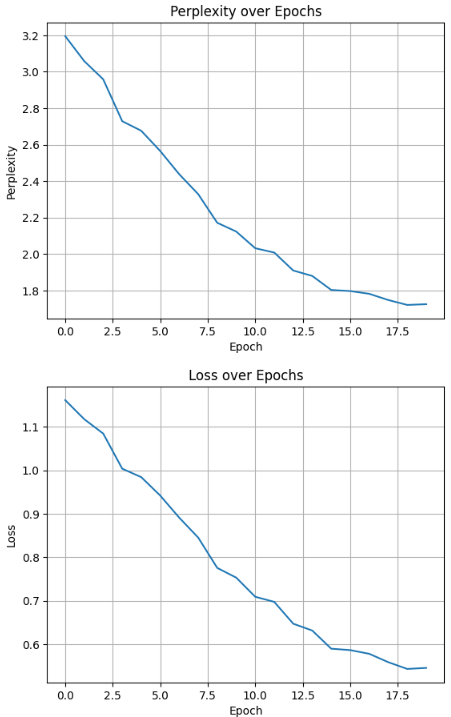

SimpleRNN (5 min ish):

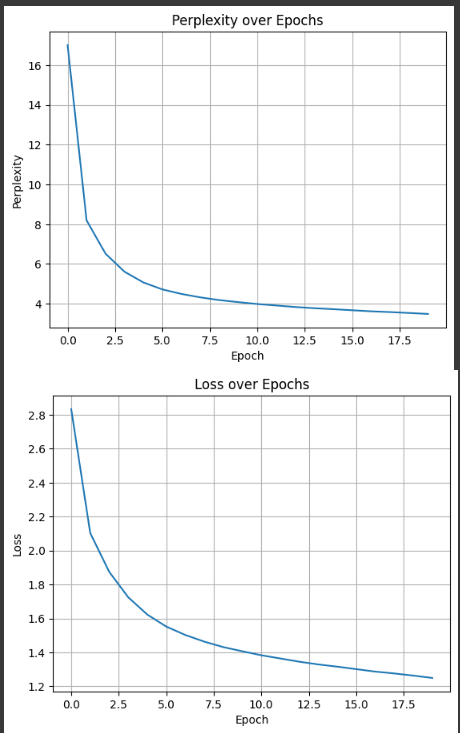

### SimpleRNN
- Perplexity: decreases from ~3.2 to ~1.7 across epochs → so it learns, but the curve is a bit less smooth.
- Loss: drops from ~1.15 to ~0.55, but the decrease is slower and seems to flatten out earlier.

Interpretation:
SimpleRNN can learn short dependencies, but it struggles with longer sequences. Training is okay, but it converges more slowly and may plateau sooner.

### GRU

- Perplexity: decreases more steadily, reaching ~1.7 as well, but the curve is smoother and drops faster early on.
- Loss: starts around 1.15 and decreases more consistently, reaching ~0.55 faster than SimpleRNN.

Interpretation:
GRU learns faster and more stably than SimpleRNN. Thanks to its gating mechanism, it captures longer-term dependencies and avoids vanishing gradients better.

### Comparison Summary

- Training speed: GRU converges faster (loss/perplexity drops more steadily).
- Convergence quality: Both models reach similar final loss/perplexity (~0.55 loss, ~1.7 perplexity), but GRU gets there more efficiently.

Overall:

- SimpleRNN = useful as a baseline, but weaker on longer sequences.
- GRU = better for capturing structure in text, more robust and efficient.

#### Generate text

The simplest way to generate text with this model is to run it in a loop, and keep track of the model's internal state as you execute it.

![To generate text the model's output is fed back to the input](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/text_generation_sampling.png?raw=1)

Each time you call the model you pass in some text and an internal state. The model returns a prediction for the next character and its new state. Pass the prediction and state back in to continue generating text.


The following makes a single step prediction:

In [ ]:
class OneStep(keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Run it in a loop to generate some text. Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['SIR:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

The easiest thing you can do to improve the results is to train it for longer (try `EPOCHS = 30`).

You can also experiment with a different start string, try adding another RNN layer to improve the model's accuracy, or adjust the temperature parameter to generate more or less random predictions.

If you want the model to generate text *faster* the easiest thing you can do is batch the text generation. In the example below the model generates 5 outputs in about the same time it took to generate 1 above.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

### Optional expert knowledge: Export the generator (model)

This single-step model can easily be [saved and restored](https://www.tensorflow.org/guide/saved_model), allowing you to use it anywhere `tf.saved_model` is accepted.

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

# Note, you will see some warnings from this block. This is due to using an older tf_keras version for this notebook, so no worries.

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

### Optional expert knowledge: Customized training

The above training procedure is simple, but does not give you much control.
It uses teacher-forcing which prevents bad predictions from being fed back to the model, so the model never learns to recover from mistakes.

So now that you've seen how to run the model manually next you'll implement the training loop. The most important part of a custom training loop is the train step function.

Use `tf.GradientTape` to track the gradients. You can learn more about this approach by reading the [eager execution guide](https://www.tensorflow.org/guide/eager).

The basic procedure is:

1. Execute the model and calculate the loss under a `tf.GradientTape`.
2. Calculate the updates and apply them to the model using the optimizer.

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

The above implementation of the `train_step` method follows [Keras' `train_step` conventions](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit). This is optional, but it allows you to change the behavior of the train step and still use keras' `Model.compile` and `Model.fit` methods.

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

Or if you need more control, you can write your own complete custom training loop:

In [ ]:
EPOCHS = 10

mean = keras.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))